In [76]:
import numpy as np
import matplotlib.pyplot as plt

import qiskit.circuit.library as clib
from qiskit.primitives import Estimator, Sampler
from qiskit.algorithms.optimizers import COBYLA
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.algorithms.gradients import ReverseQGT, ReverseEstimatorGradient
from qiskit.algorithms.gradients import ParamShiftStateFidelityGradient

from qiskit.quantum_info import SparsePauliOp

In [224]:
def solve(A, b, reg=0):
    def quadratic(x):
        return 0.5 * x.dot((A + np.eye(b.size) * reg).dot(x)) - b.dot(x)
    x0 = np.zeros_like(b)
    return COBYLA().minimize(quadratic, x0).x

In [257]:
def linesearch(f, x, direction):
    def value(alpha):
        return f(x + alpha * direction)
    
    return COBYLA().minimize(value, x0=[0.01]).x[0]

In [31]:
def update(theta_next, theta, grad_f, hessian):
    s = theta_next - theta
    t = hessian.dot(s)
    y = grad_f(theta_next) - grad_f(theta)
    
    alpha = 1 / y.dot(s)
    beta = -1 / s.dot(t)
    
    next_hessian = hessian + alpha * np.outer(y, y) + beta * np.outer(t, t)
    return next_hessian

In [32]:
sampler = Sampler()
fid = ComputeUncompute(sampler)
fid_grad = ParamShiftStateFidelityGradient(fid)

In [232]:
circuit = clib.RealAmplitudes(3, reps=2, entanglement="linear")
v0 = np.zeros(circuit.num_parameters)

In [233]:
def qgt(parameters):
    return ReverseQGT().run([circuit], [parameters]).result().qgts[0]

In [237]:
g0 = qgt(v0)

v0 = np.zeros(circuit.num_parameters)
v0[-circuit.num_qubits:] = np.pi / 2
# op = SparsePauliOp(["XX", "YY", "ZZ", "ZI", "IZ"])
op = SparsePauliOp.from_sparse_list(
    [("ZZ", [i, i + 1], 1) for i in range(circuit.num_qubits - 1)] 
    + [("X", [i], -1) for i in range(circuit.num_qubits)],
    circuit.num_qubits
)

b0 = -0.5 * ReverseEstimatorGradient().run([circuit], [op], [v0]).result().gradients[0].real

In [238]:
def gd(op, circuit, initial_point, eta=0.01, maxiter=100):
    def energy(parameters):
        return Estimator().run(circuit, op, parameters).result().values[0].real
    
    def grad(parameters):
        return ReverseEstimatorGradient().run([circuit], [op], [parameters]).result().gradients[0].real
    
    points = [initial_point]
    energies = [energy(initial_point)]

    for _ in range(maxiter):
        gradient = grad(points[-1])
        
        next_point = points[-1] - eta * gradient
        points.append(next_point)
        energies.append(energy(next_point))
        
    return points, energies

In [239]:
def qng(op, circuit, initial_point, eta=0.01, maxiter=100, reg=0.01):
    def energy(parameters):
        return Estimator().run(circuit, op, parameters).result().values[0].real
    
    def qgt(parameters):
        return ReverseQGT().run([circuit], [parameters]).result().qgts[0]
    
    def grad(parameters):
        return ReverseEstimatorGradient().run([circuit], [op], [parameters]).result().gradients[0].real
    
    points = [initial_point]
    energies = [energy(initial_point)]
    g = []

    for _ in range(maxiter):
        g.append(qgt(points[-1]))
        gradient = grad(points[-1])
        update = solve(g[-1], gradient, reg=reg)
        
        next_point = points[-1] - eta * update
        points.append(next_point)
        energies.append(energy(next_point))
        
    return points, energies, g

In [270]:
def qnbfgs(op, circuit, initial_point, eta=0.01, maxiter=100, reg=0.01):
    def energy(parameters):
        return Estimator().run(circuit, op, parameters).result().values[0].real
    
    def qgt(parameters):
        return ReverseQGT().run([circuit], [parameters]).result().qgts[0]
    
    def grad(parameters):
        return ReverseEstimatorGradient().run([circuit], [op], [parameters]).result().gradients[0].real
    
    sampler = Sampler()
    fid = ComputeUncompute(sampler)
    fid_grad = ParamShiftStateFidelityGradient(fid)
    
    def fidelity_grad(theta, theta_next):
        return fid_grad.run(circuit, circuit, theta_next, theta).result().gradients[0].real
    
    # initial step
    g0 = qgt(initial_point)
    b0 = grad(initial_point)
    u0 = solve(g0, b0)
    
    if eta == "linesearch":
        alpha = linesearch(energy, initial_point, -u0)
    else:
        alpha = eta
    
    points = [initial_point, initial_point - alpha * u0]
    energies = [energy(point) for point in points]
    g = [g0]
    b = [b0]    
    
    for _ in range(maxiter - 1):
        s = -2 * (points[-1] - points[-2])
        y = fidelity_grad(points[-2], points[-1])
        
        g_next = step(s, y, g[-1])
        g.append(g_next)
        
        b.append(grad(points[-1]))
        
        u = solve(g[-1], b[-1], reg=reg)
        
        if eta == "linesearch":
            alpha = linesearch(energy, initial_point, -u)
        else:
            alpha = eta
        
        next_point = points[-1] - alpha * u
        points.append(next_point)
        energies.append(energy(next_point))
        
    return points, energies, g

In [241]:
def qnbfgs_i0(op, circuit, initial_point, eta=0.01, maxiter=100, reg=0.01):
    def energy(parameters):
        return Estimator().run(circuit, op, parameters).result().values[0].real
    
    def qgt(parameters):
        return ReverseQGT().run([circuit], [parameters]).result().qgts[0]
    
    def grad(parameters):
        return ReverseEstimatorGradient().run([circuit], [op], [parameters]).result().gradients[0].real
    
    sampler = Sampler()
    fid = ComputeUncompute(sampler)
    fid_grad = ParamShiftStateFidelityGradient(fid)
    
    def fidelity_grad(theta, theta_next):
        return fid_grad.run(circuit, circuit, theta_next, theta).result().gradients[0].real
    
    # initial step
    g0 = qgt(initial_point)
    b0 = grad(initial_point)
    u0 = solve(g0, b0)
    
    points = [initial_point, initial_point - eta * u0]
    energies = [energy(point) for point in points]
    g = [g0]
    b = [b0]    
    
    for _ in range(maxiter - 1):
        g.append(g0)
        
        b.append(grad(points[-1]))
        
        u = solve(g[-1], b[-1], reg=reg)
        next_point = points[-1] - eta * u
        points.append(next_point)
        energies.append(energy(next_point))
        
    return points, energies, g

In [203]:
eta = 0.01
qng_points, qng_energies, qng_g = qng(op, circuit, v0, eta=eta, maxiter=100)

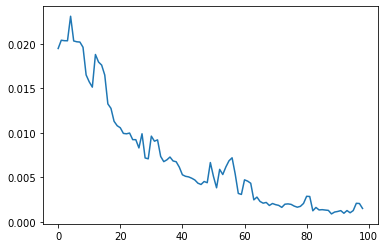

In [204]:
diffs = [np.linalg.norm(d) for d in np.diff(qng_g, axis=0)]
plt.plot(diffs)

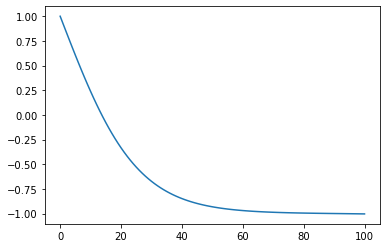

In [205]:
plt.plot(qng_energies)

In [267]:
eta = 0.001
maxiter = 600
reg = 0.01
qng_points, qng_energies, qng_g = qng(op, circuit, v0, eta=eta, maxiter=maxiter, reg=reg)

In [261]:
gd_points, gd_energies = gd(op, circuit, v0, eta=eta, maxiter=maxiter)

In [268]:
points, energies, g = qnbfgs(op, circuit, v0, eta=eta, maxiter=maxiter, reg=reg)

In [271]:
points_ls, energies_ls, g_ls = qnbfgs(op, circuit, v0, eta="linesearch", maxiter=100, reg=reg)

In [269]:
points_i0, energies_i0, g_i0 = qnbfgs_i0(op, circuit, v0, eta=eta, maxiter=maxiter, reg=reg)

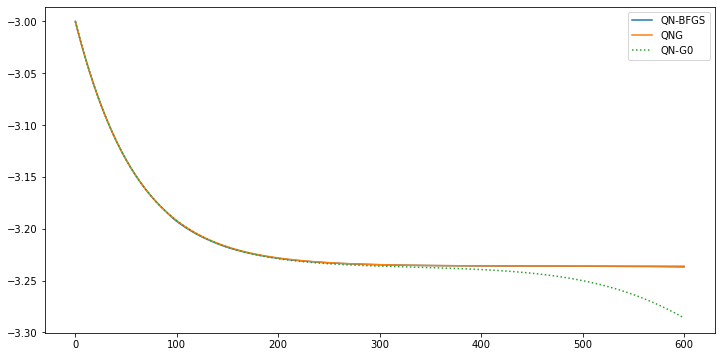

In [274]:
plt.figure(figsize=(12, 6))
plt.plot(energies, label="QN-BFGS")
plt.plot(qng_energies, label="QNG")
# plt.plot(gd_energies, ls="--", label="GD")
# plt.plot(energies_i0, ls=":", label="QN-G0")
# plt.plot(energies_ls, ls=":", label="QN-BFGS + ls")
plt.legend(loc="best")

In [275]:
def compare(eta, maxiter):
    reg = 0.01
    qng_points, qng_energies, qng_g = qng(op, circuit, v0, eta=eta, maxiter=maxiter, reg=reg)
    points, energies, g = qnbfgs(op, circuit, v0, eta=eta, maxiter=maxiter, reg=reg)
    points_i0, energies_i0, g_i0 = qnbfgs_i0(op, circuit, v0, eta=eta, maxiter=maxiter, reg=reg)
    
    return qng_energies, energies, energies_i0

In [277]:
results = {0.001: [qng_energies, energies, energies_i0]}
for eta in [0.01, 0.005]:
    maxiter = int(0.6 / eta)
    results[eta] = compare(eta, maxiter)

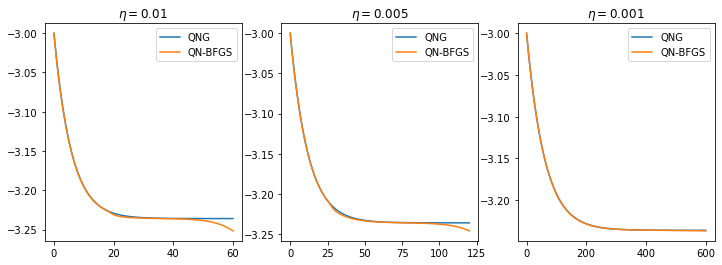

In [290]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for ax, eta in zip(axs, [0.01, 0.005, 0.001]):
    ax.set_title("$\eta = {eta}$".format(eta=eta))
    ax.plot(results[eta][0], label="QNG")
    ax.plot(results[eta][1], label="QN-BFGS")
    ax.legend(loc="best")
#     ax.plot(results[eta][2])

In [211]:
def error(approx_energies):
    return np.abs(np.asarray(approx_energies) - np.asarray(qng_energies))

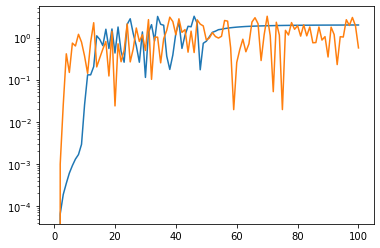

In [212]:
plt.semilogy(error(energies))
plt.semilogy(error(energies_i0))

In [213]:
diffs = [np.linalg.norm(d) for d in np.diff(exact_qgts, axis=0)]

In [214]:
np.linalg.norm(exact_qgts[0] - exact_qgts[1])

0.008816443380078903

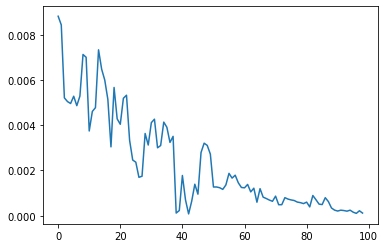

In [215]:
plt.plot(diffs)

In [155]:
exact_qgts[-1]

array([[2.50000000e-01+0.j, 1.07980147e-20+0.j, 3.33922764e-04+0.j,
        3.28166508e-19+0.j],
       [1.07980147e-20+0.j, 2.50000000e-01+0.j, 1.38777878e-17+0.j,
        8.41136887e-03+0.j],
       [3.33922764e-04+0.j, 1.38777878e-17+0.j, 2.50000000e-01+0.j,
        2.49858235e-01+0.j],
       [3.28166508e-19+0.j, 8.41136887e-03+0.j, 2.49858235e-01+0.j,
        2.50000000e-01+0.j]])

In [194]:
m = len(energies) - 1
exact_qgts = ReverseQGT().run(m * [circuit], points[:-1]).result().qgts
errors = [np.linalg.norm(exact - approx) for exact, approx in zip(exact_qgts, g)]
do_nothing = [np.linalg.norm(exact - g[0]) for exact in exact_qgts]

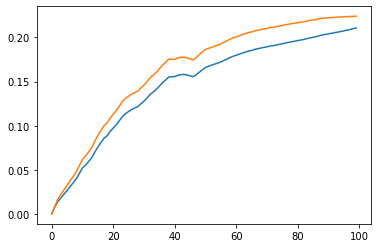

In [195]:
plt.plot(errors)
plt.plot(do_nothing)
# plt.plot(xerrors)
# plt.plot(yerrors)